# Image Inpainting using Machine Learning

Landson Guo tlguo@uwaterloo.ca

Yiqing(Jack) Zhao y572zhao@uwaterloo.ca

# Abstract

Image inpainting is the problem of trying to fill in missing areas of an image using contextual details of the surrounding pixels. This can ultimately be used for object removal techniques and photo editing. We decided to tackle this problem as it presented the opportunity to explore how advanced machine learning techniques can be used for image processing and see the effectiveness of such models.

In particular, we decided to focus on Generative Adversarial Networks as they are shown in https://openaccess.thecvf.com/content_cvpr_2016/papers/Pathak_Context_Encoders_Feature_CVPR_2016_paper.pdf to have better results compared to simpler loss-function based machine learning techniques. For our training, we used 41000 images from the Places205 dataset that were resized to be 256x256 pixels, accessible at http://data.csail.mit.edu/places-private/places205/testSetPlaces205_resize.tar.gz. These images had random rectangular masks applied to them and the masked images were used for training the models.

As a baseline, we trained a simple U-net generator using only MSE loss. We then experimented with the following different variations of GAN networks using different architectures and loss functions to see how the performance compares. These are as follows:

- Simple GAN with MSE Loss:
    - Our simple GAN has two parts, a generator and a discriminator. In a GAN model, the generator is what actually generates the images while the discriminator tries to guide the generator by determining if an image looks "real" or "fake".
        - The generator is a U-Net architecture using multiple convolution, BatchNorm, and ReLu layers to generate an embedding for the image before using transpose-convolution, BatchNorm, and ReLu layers to upscale back to the original image size.
        - The discriminator is a simple convolutional neural net that classifies images using a sequence of convolution, BatchNorm, and ReLu layers into a final linear layer output. 
    - Mean Squared Error is the simplest loss function to use, so we started with using this as our loss function
- Simple GAN with updated loss function:
    - Since the discriminator in a GAN network is really a classifier trying to label images as real or fake, we can use BCE Loss as a better measure of the difference in the discriminator's predicted label versus the actual label.
    - The new loss function is as follows:
        - For discriminator: BCELoss between predicted fake/real images and the true labels
        - For generator: BCELoss between dicriminator performance on its images and MSE loss on the image. We give higher weight to the MSE loss to enforce color and image consistency.
- GAN using Residual Blocks
    - Many state-of-the-art image inpainting networks have a set of blocks in the middle of the U-Net that appears to boost performance. These vary from network to network, such as Dialated Convolution layers in https://dl.acm.org/doi/pdf/10.1145/3072959.3073659 or Fourier Convolution blocks in https://arxiv.org/pdf/2109.07161.pdf. We decided to try using basic Residual blocks as they would be faster to train while potentially still resulting in increased performance due to the depth of the network.
    - We trained two versions of this network. One produced only the masked region of the image and copied the unmasked areas, while the other tried to reproduce the whole image from within the network. The thought behind this was that forcing the network to produce the whole image may result in better colour consistency.
- GAN with double discriminator
    - When training the other model variations we noticed the models had a hard time being consistent with the rest of the image. Oftentimes the colour values would be off by some constant degree, making the inpainted area very obvious. Inspired by the architecture in https://dl.acm.org/doi/pdf/10.1145/3072959.3073659, we tried having two discriminators to nudge the model for better photoconsistency, one for the local area of the mask and one for the global image as a whole.
    - Inspired by https://arxiv.org/pdf/1801.07892.pdf, we duplicate the structure of the generator so it consisted of Downscale -> Residual -> Upscale followed by a second series of Downscale -> Residual -> Upscale (previous models contained only one series). This essentially adds a second "refinement network" after the initial model to produce more accurate results. However, to simplify the model a little bit we removed the skip connection in the U-Net.
    - This model also employed a more complicated random mask generator, being able to generate circular and elliptical masks in addition to the normal rectangular ones. We hoped that with more varied masks, this could entice the model to pay more attention to finer details and produce sharper output.
    - Since this was the final model we trained, we decided to train it for a total of 50 epochs instead of 20 for better results.

# Team Members and Contributions

- Landson Guo tlguo@uwaterloo.ca
    - Model tuning/debugging
    - Report
- Yiqing(Jack) Zhao y572zhao@uwaterloo.ca
    - Model interactive demo
    - Model tuning/debugging
    - Ran the models on his beefy computer :P


# Results and Conclusions

We split our models into sub-notebooks to keep this report more readable. To see the code for each specific model, refer to its corresponding notebook.

- Baseline Network (generator_only.ipynb):
    - The inpainting result by this network managed to roughly reproduce the shape of the lighthouse, but the inpainted area is very blurred and the colours don't match exactly. By comparing the generator output with the unmasked section of the image we are able to mostly correct the colour errors, the inpainted area is still very distinct from the rest of the image.

    MSE loss is mostly concerned with minimizing outliers in the data, so it makes sense why the end result is blurry. It is difficult to say why the shift in colour occurs: perhaps the amount of epochs is insufficient, or MSE Loss is unequally affecting the different colour channels of the image.
    
    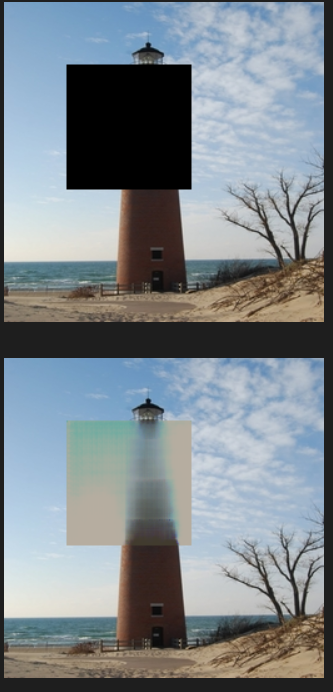
    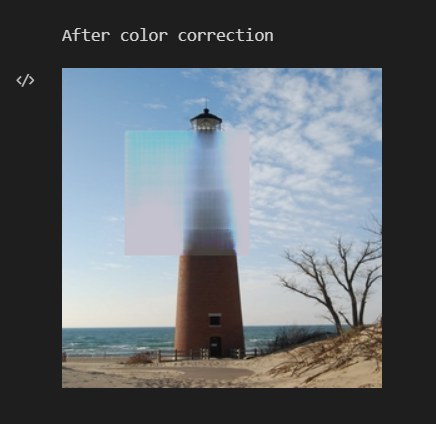

- Simple GAN (basic_gan.ipynb):
    - The simple GAN performed very poorly using pure MSE loss, indicating that this is not the loss function to use and resulted in garbage output.
    
    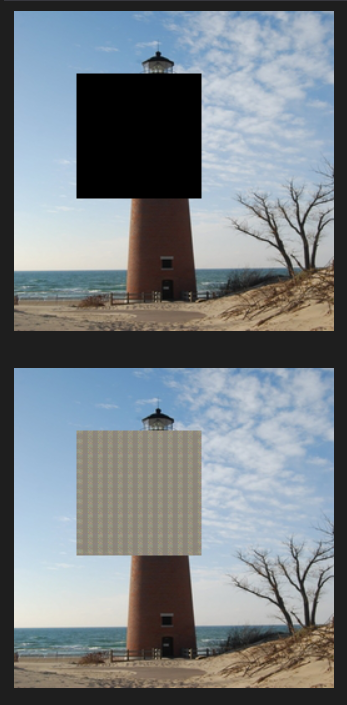
    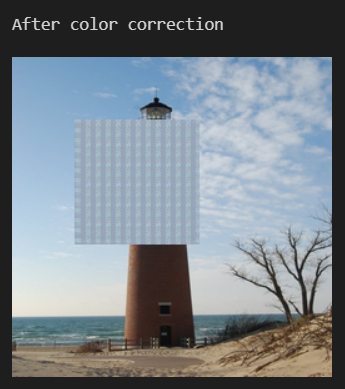



- Simple GAN with Updated Loss (gan_new_loss.ipynb)
    - When combining MSE with BCE loss, instead of producing garbage ouput we can start to see the basic outline of the lighthouse once again. However, the colour accuracy is still poor and the result is incredibly noisy. 

    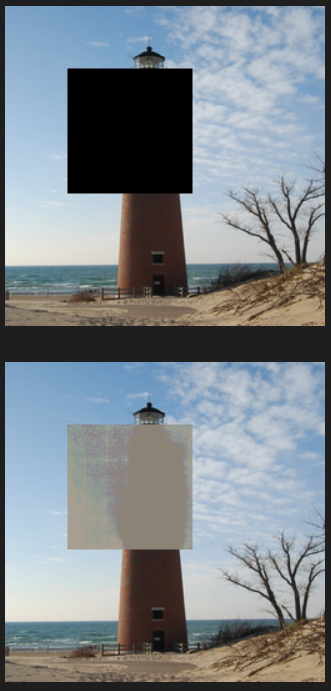
    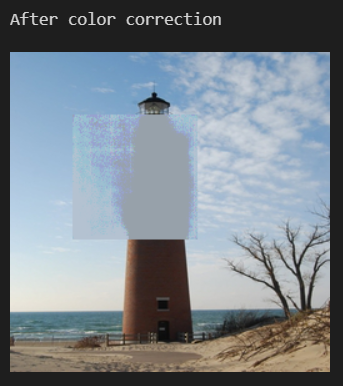

- GAN model with residual blocks (gan_res_mask):
    - This model actually ended up performing similarly to the baseline Generator Only model. The colour was off by a similar amount as the baseline model, indicating that the problem with either insufficient epochs or MSE Loss still exists. However, due to the introduction of the discriminator the lighthouse is more defined and less blurry than in the baseline model, as the adversarial training means blurry images can be more easily picked up by the detector.

    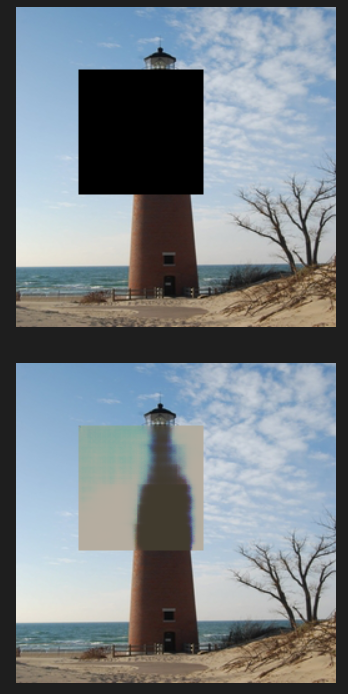
    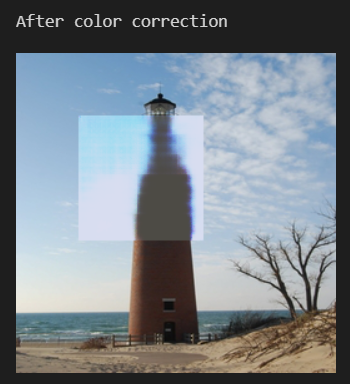


- GAN model with residual blocks producing the entire image (gan_res_whole.ipynb):
    - The GAN model in this case is producing the entire image rather than just the masked region. Our hope was that this would improve the colour consistency of the model, but that appears not to have been the case (colour errors remain about the same). Instead, the model focused less on producing a proper lighthouse, resulting in a poorer result overall. 

    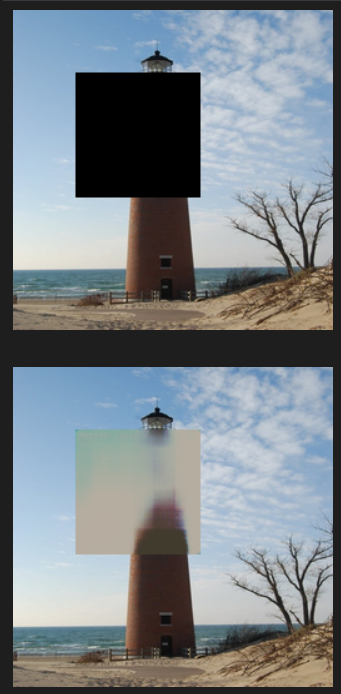
    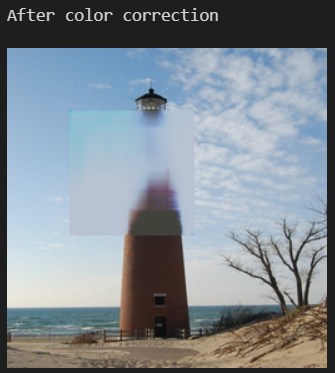


- GAN model with two discriminators (gan_double_dg.ipynb):
    - The goal of this model was to borrow the architecture from https://dl.acm.org/doi/pdf/10.1145/3072959.3073659 and https://arxiv.org/pdf/1801.07892.pdf in addition to an expanded mask randomization function to produce sharper, more colour-accurate results.
    
    After 20 epochs, the model looked like this (random circular mask in bottom right corner):

    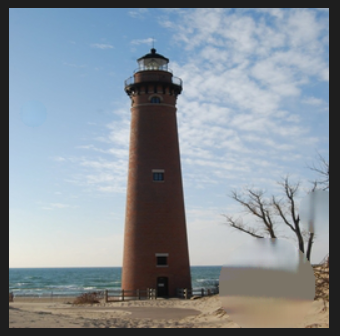

    After 50 epochs, it looked like this (same standard mask as all the other images):
    
    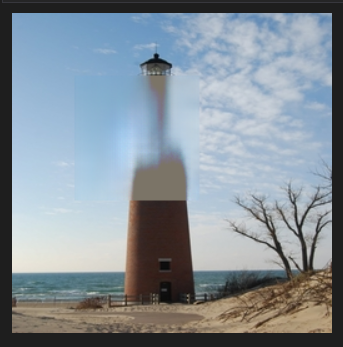


    We can see the shape of the lighthouse is somewhere inbetween the two versions of the Residual Block network, where the basic shape of the lighthouse is there but the sky bleeds into it slightly. However, thanks to the additional refinement network and additional discriminator we no longer need to colour correct the images. The edges of the mask are still visible to the human eye and the inpainted areas as still a bit blurry, but overall shapes are captured well. 

# Interactive Demo

The following is a little interactive demo that you can use to test our best performing model (the two discriminator model). You can see how it performs with arbitrary masks on the test image.

In [5]:
from PIL import Image
import numpy as np
import ipywidgets as widgets
from io import BytesIO
from ipycanvas import Canvas, hold_canvas, MultiCanvas
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import torch.fft
from torchvision import transforms

In [6]:
class DownscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownscaleBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return x + self.conv(x)

class UpscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downscale1 = nn.Sequential(
            DownscaleBlock(6, 64),
            DownscaleBlock(64, 128),
            DownscaleBlock(128, 256),
        )
        self.residual1 = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
        )
        self.upscale1 = nn.Sequential(
            UpscaleBlock(256, 128),
            UpscaleBlock(128, 64),
            UpscaleBlock(64, 3),
        )
        self.downscale2 = nn.Sequential(
            DownscaleBlock(6, 64),
            DownscaleBlock(64, 128),
            DownscaleBlock(128, 256),
        )
        self.residual2 = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
        )
        self.upscale2 = nn.Sequential(
            UpscaleBlock(256, 128),
            UpscaleBlock(128, 64),
            UpscaleBlock(64, 3),
        )

    def forward(self, x, mask):
        x_masked = x * mask
        x1 = torch.cat((x_masked, mask), dim=1)
        x1 = self.downscale1(x1)
        x1 = self.residual1(x1)
        x1 = self.upscale1(x1)
        inpainted = x_masked + x1 * (1 - mask)
        x2 = torch.cat((inpainted, mask), dim=1)
        x2 = self.downscale2(x2)
        x2 = self.residual2(x2)
        x2 = self.upscale2(x2)
        refined = inpainted + x2 * (1 - mask)
        return refined
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
image_size = 256
stroke_size = 5

image = np.array([])
left_canvas = MultiCanvas(2, width=image_size, height=image_size, sync_image_data=True)
right_canvas = Canvas(width=image_size, height=image_size, sync_image_data=True)
left_canvas[1].global_alpha=0.5
left_canvas[1].sync_image_data=True
is_drawing = False
is_uploaded = False
output = widgets.Output()
position = [0, 0]
mask = np.array([])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to("cuda")
generator.load_state_dict(torch.load("generator_new_50.pth"))

def upload_image(change):
    with output:
        global image, is_uploaded
        left_canvas.clear()
        image = np.array(Image.open(BytesIO(change.new[0]["content"])).crop((0, 0, image_size, image_size)))
        left_canvas[0].put_image_data(image)
        right_canvas.clear()
        is_uploaded = True

def paint_on_left(x, y):
    if not is_uploaded:
        return
    with output:
        with hold_canvas():
            left_canvas[1].stroke_style = "red"
            left_canvas[1].line_width = stroke_size
            if is_drawing:
                left_canvas[1].begin_path()
                left_canvas[1].move_to(position[0], position[1])
                left_canvas[1].line_to(x, y)
                left_canvas[1].stroke()
                left_canvas[1].close_path()
            position[0] = x
            position[1] = y

def confirm_preview(change):
    if not is_uploaded:
        return
    global image
    with hold_canvas():
        image = right_canvas.get_image_data().copy()
        left_canvas[0].put_image_data(image)
        left_canvas[1].clear()
        right_canvas.clear()

def revert_changes(change):
    if not is_uploaded:
        return
    global mask
    with hold_canvas():
        left_canvas[1].clear()
        mask = np.zeros_like(mask)
        right_canvas.clear()

def start_drawing(x, y):
    if not is_uploaded:
        return
    global is_drawing
    is_drawing = True

def stop_drawing(x, y):
    if not is_uploaded:
        return
    with output:
        global is_drawing, mask, image
        is_drawing = False
        mask = left_canvas[1].get_image_data()
        mask = mask[:,:,3]!=0
        with hold_canvas():
            image_temp = image.copy()
            image_temp = transform(image_temp).unsqueeze(0).to(device)
            mask_temp = np.ones_like(image)
            mask_temp[mask] = 0
            mask_temp = torch.from_numpy(mask_temp).permute(2, 0, 1).unsqueeze(0).float().to(device)
            image_temp = generator(image_temp, mask_temp)
            image_temp = image_temp.squeeze(0)
            image_temp = image_temp.detach().cpu()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image_temp = image_temp * std + mean
            image_temp = image_temp.numpy()
            image_temp = np.transpose(image, (1, 2, 0))
            image_temp = (image_temp * 255).astype(np.uint8)
            image_temp = Image.fromarray(image_temp)
            right_canvas.put_image(image_temp)
    
def stroke_changed(change):
    global stroke_size
    stroke_size = change.new

def save_result(change):
    if not is_uploaded:
        return
    result = right_canvas.to_file()
    with open("result.png", "wb") as f:
        f.write(result.getbuffer())
    print("Result saved as result.png")


In [8]:
upload_button = widgets.FileUpload(accept="image/*", multiple=False)
upload_button.observe(upload_image, names="value")

left_canvas.on_mouse_move(paint_on_left)

confirm_button = widgets.Button(description="Confirm")
confirm_button.on_click(confirm_preview)

revert_button = widgets.Button(description="Revert")
revert_button.on_click(revert_changes)

save_button = widgets.Button(description="Save")
save_button.on_click(save_result)

stroke_size_change = widgets.IntText(value=stroke_size, description='Stroke Size:', disabled=False)
stroke_size_change.observe(stroke_changed, 'value')

left_canvas.on_mouse_down(start_drawing)
left_canvas.on_mouse_up(stop_drawing)

display(widgets.HBox([left_canvas, right_canvas]))
display(stroke_size_change)
display(widgets.HBox([upload_button, confirm_button, revert_button, save_button]))
display(output)

IntText(value=5, description='Stroke Size:')

Output()

# Future Improvements

Due to computational power and time restraints we restricted our tests to 20 epochs and used a (somewhat) small dataset of only 41000 images. Especially since our models are very deep (19 layers for the residual neural nets) they could be improved with larger datasets and more training time.

One improvement we could have made to the model is using a feature extractor like VGG16 or a semantic neural net and comparing the differences between the features detected in the original image and the generated image. Using high level features as a loss could serve as an "attention" that gets the model to pay attention to semantic details and assist in producing believable results. This has been shown to be effective in other image processing tasks such as real-time style transfer and super-resolution as shown in https://arxiv.org/abs/1603.08155, so we have reason to believe it would also be effective here.